## Using `pyodk` and `pandas` for basic analysis

`pyodk` simplifies connecting to ODK Central using Python. 🐍


*If your preferred data science language is [R](https://www.r-project.org/), check out [`ruODK`](https://github.com/ropensci/ruODK) and [`repvisforODK`](https://forum.getodk.org/t/repvisforodk-quickly-visualize-your-odk-data-in-r/36564).*

To get started with `pyodk`, you'll need to configure a Central server you'd like to connect to. Create a `.pyodk_config.toml` file in your home directory. Copy the following configuration and replace the placeholders:

```
[central]
base_url = "https://www.example.com"
username = "my_user"
password = "my_password"
default_project_id = 123
```

`pyodk` will use these credentials and defaults so that they never have to appear in your Python code.

To use these examples as-is, you will need to put [this form definition](fav_color.xlsx) on your server and make a few submissions.

You will need to create a `Client` to establish a connection to your configured Central server so let's import the class. We'll also be using the `pandas` library.

In [2]:
import pandas as pd
from pyodk.client import Client

### Downloading and analyzing data
You can download a data table and use tools like [`pandas`](https://pandas.pydata.org/) and [`geopandas`](https://geopandas.org/en/stable/) to explore and analyze it.

In [4]:
with Client() as client:
    submissions = client.submissions.get_table(form_id="fav_color")
    df = pd.json_normalize(data=submissions["value"], sep="/")

df.head(3)

,__id,first_name,age,favorite_color,favorite_color_other,location/type,location/coordinates,location/properties/accuracy,meta/audit,meta/instanceID,...,__system/submitterId,__system/submitterName,__system/attachmentsPresent,__system/attachmentsExpected,__system/status,__system/reviewState,__system/deviceId,__system/edits,__system/formVersion,location
0,uuid:7993ed66-5f17-432d-896c-fd9cbc76bf07,Tochakwa,37,o,Blue,Point,"[7.436423, 10.528851, 646.1000366210938]",16.204,None,uuid:7993ed66-5f17-432d-896c-fd9cbc76bf07,...,548,WHO,0,0,None,rejected,None,0,2022062100,NaN
1,uuid:f1b96b04-4cf8-4bdf-8eeb-b1f2893e2022,John Doe,50,g,None,Point,"[17.071151, -22.555347, 1711.5999755859375]",17.416,None,uuid:f1b96b04-4cf8-4bdf-8eeb-b1f2893e2022,...,548,WHO,0,0,None,None,None,0,2022062100,NaN
2,uuid:3a470336-2de5-46eb-9da5-3a03815f9fde,Zeenia,19,y,None,Point,"[-117.1115681395832, 32.773376588223655, 68.08...",0.000,audit.csv,uuid:d1c762c8-51ee-4966-a14b-5d50427c1534,...,56,Yaw,1,1,None,rejected,collect:cAOhxkeJksuCQfjE,1,2022062100,NaN


You can build graphs from form data:

<AxesSubplot:title={'center':'Count of favorite colors'}, xlabel='Color', ylabel='Count'>

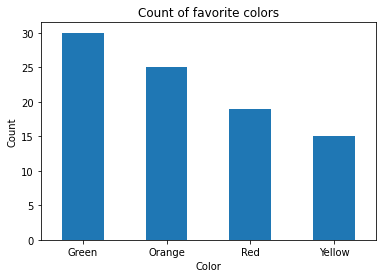

In [5]:
colors = {"g": "Green", "o": "Orange", "r": "Red", "y": "Yellow"}
df["favorite_color_labels"] = df["favorite_color"].map(colors)
df["favorite_color_labels"].value_counts().plot(
    kind="bar", title="Count of favorite colors", xlabel="Color", ylabel="Count", rot=0
)

You can also analyze form metadata such as review state:

<AxesSubplot:title={'center':'Submission review state'}>

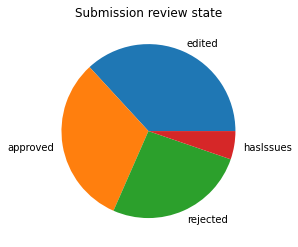

In [6]:
df["__system/reviewState"].value_counts().plot(
    kind="pie", title="Submission review state", ylabel="", rot=0
)

With `geopandas`, you can quickly plot points or create [choropleth maps](https://geopandas.org/en/stable/docs/user_guide/mapping.html#choropleth-maps):

<AxesSubplot:>

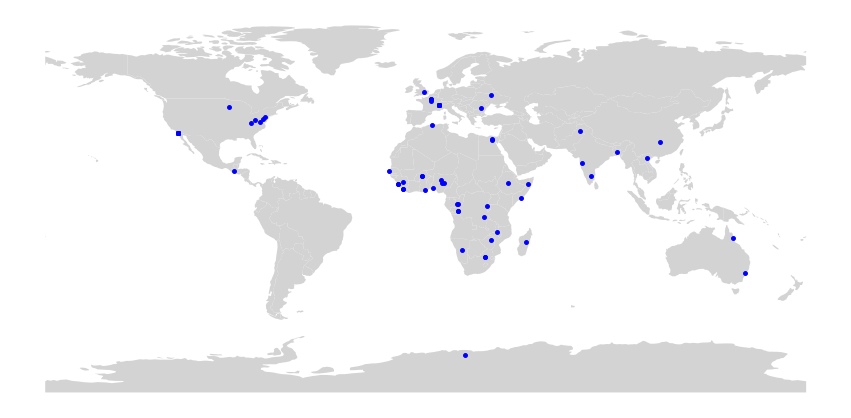

In [7]:
import geopandas
from geopandas import GeoDataFrame

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
base = world.plot(color="lightgrey", figsize=(15, 10))
base.set_axis_off()

locations = pd.DataFrame(
    df["location/coordinates"].dropna().to_list(), columns=["x", "y", "alt"]
)
geodf = GeoDataFrame(
    locations, geometry=geopandas.points_from_xy(locations["x"], locations["y"])
)
geodf.plot(ax=base, marker="o", color="blue", markersize=15)